# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast  # Add these imports for mixed precision training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import os
import shutil
import subprocess
import zipfile
import re
import random
from sklearn.preprocessing import MinMaxScaler

## Global Definitions

In [2]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [3]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

window_size = 7
input_size = 1
hidden_size = 4
num_stacked_layers = 2
loss_function = nn.MSELoss()
learning_rate = 0.001
bach_size = 16


2.5.1
None
90100
True


### Utilities 

In [4]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")  # Debugging shapes
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    print(f"Shape of X_tensor: {X_tensor.shape}, Shape of y_tensor: {y_tensor.shape}")  # Debugging shapes
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_one_epoch(model, train_loader, optimizer, loss_function, epoch):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    avg_loss_across_batches = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss_across_batches = running_loss / 100
        print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                avg_loss_across_batches))
    return avg_loss_across_batches


def validate_one_epoch(model, val_loader):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(val_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(val_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************\n')
    return avg_loss_across_batches

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, teacher_forcing_prob=0.5):
    """
    Train the given model with validation and return training/validation metrics.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    huber_criterion = nn.HuberLoss(delta=1.0)  # Use HuberLoss
    mae_criterion = nn.L1Loss()

    train_losses, val_losses = [], []
    train_mae_losses, val_mae_losses = [], []

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state

    for epoch in range(epochs):
        avg_loss_across_batches_train = train_one_epoch(model=model, train_loader=train_loader, optimizer=optimizer, loss_function=huber_criterion, epoch=epoch)
        train_losses.append(avg_loss_across_batches_train)
        # Validate the model after each epoch
        avg_loss_across_batches_val = validate_one_epoch(model=model, val_loader=val_loader)
        val_losses.append(avg_loss_across_batches_val)


    #     # Training phase
    #     model.train()
    #     total_train_huber, total_train_mae, total_train_samples = 0.0, 0.0, 0
    #     pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    #     for batch_x, batch_y in pbar:
    #         batch_x, batch_y = batch_x.to(device), batch_y.to(device)

    #         # Forward pass
    #         preds = model(batch_x)

    #         # Teacher forcing
    #         if random.random() < teacher_forcing_prob:
    #             batch_x = batch_x.clone()
    #             batch_x[:, -1, 0] = batch_y[:, 0]

    #         # Compute loss
    #         loss = huber_criterion(preds, batch_y)

    #         # Backward pass
    #         optimizer.zero_grad()
    #         loss.backward()
    #         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    #         optimizer.step()

    #         # Track training metrics
    #         batch_size = batch_x.size(0)
    #         total_train_samples += batch_size
    #         total_train_huber += huber_criterion(preds, batch_y).item() * batch_size
    #         total_train_mae += mae_criterion(preds, batch_y).item() * batch_size

    #         pbar.set_postfix(huber_loss=loss.item())

    #     avg_train_huber = total_train_huber / total_train_samples
    #     avg_train_mae = total_train_mae / total_train_samples
    #     train_huber_losses.append(avg_train_huber)
    #     train_mae_losses.append(avg_train_mae)

    #     # Validation phase
    #     model.eval()
    #     total_val_huber, total_val_mae, total_val_samples = 0.0, 0.0, 0
    #     with torch.no_grad():
    #         for batch_x, batch_y in val_loader:
    #             batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    #             preds = model(batch_x)

    #             batch_size = batch_x.size(0)
    #             total_val_samples += batch_size
    #             total_val_huber += huber_criterion(preds, batch_y).item() * batch_size
    #             total_val_mae += mae_criterion(preds, batch_y).item() * batch_size

    #     avg_val_huber = total_val_huber / total_val_samples
    #     avg_val_mae = total_val_mae / total_val_samples
    #     val_huber_losses.append(avg_val_huber)
    #     val_mae_losses.append(avg_val_mae)

    #     # Save the best model
    #     if avg_val_huber < best_val_loss:
    #         best_val_loss = avg_val_huber
    #         best_model_state = model.state_dict()

    #     # Adjust learning rate
    #     scheduler.step()

    #     print(f"Epoch {epoch+1}: Train Huber={avg_train_huber:.4f}, Val Huber={avg_val_huber:.4f}, Train MAE={avg_train_mae:.4f}, Val MAE={avg_val_mae:.4f}")

    # # Load the best model
    # model.load_state_dict(best_model_state)

    return train_losses, val_losses, train_mae_losses, val_mae_losses

def plot_metrics(train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses, predictions_rescaled, actual_values, save_path="training_summary.png"):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Define the number of epochs
    epochs = len(train_mse_losses)
    epoch_ticks = range(1, epochs + 1)  # Epoch numbers start from 1

    # Plot MSE Loss
    plt.subplot(1, 3, 1)
    plt.plot(epoch_ticks, train_mse_losses, label="Train MSE", color="blue")
    plt.plot(epoch_ticks, val_mse_losses, label="Val MSE", color="orange")
    plt.xticks(epoch_ticks)  # Set x-axis ticks to integer epoch numbers
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Mean Squared Error (MSE) Loss")
    plt.legend()

    # # Plot MAE Loss
    # plt.subplot(1, 3, 2)
    # plt.plot(epoch_ticks, train_mae_losses, label="Train MAE", color="green")
    # plt.plot(epoch_ticks, val_mae_losses, label="Val MAE", color="red")
    # plt.xticks(epoch_ticks)  # Set x-axis ticks to integer epoch numbers
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.title("Mean Absolute Error (MAE) Loss")
    # plt.legend()

    # Plot Actual vs Predicted Values
    plt.subplot(1, 3, 3)
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   


def recursive_forecast(model, init_window, steps=200):
    """
    Perform recursive forecasting using the trained model.

    Args:
        model: The trained Transformer model.
        init_window: The initial sequence window (tensor).
        steps: Number of forecasting steps.
        std: Standard deviation used for normalization.
        mean: Mean used for normalization.

    Returns:
        np.array: Forecasted values rescaled to the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            pred = model(current_seq.unsqueeze(0))  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred[0, 0].item()  # Extract the first step of the forecast

            # Debugging: Print the prediction for the current step
            if step < 10:  # Print only the first 10 predictions for brevity
                print(f"Step {step}: Prediction={pred_value}")

            # Append the prediction
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            current_seq = torch.cat((current_seq[1:], torch.tensor([[pred_value]], device=device)), dim=0)

            # # Optional: Clamp predictions to avoid divergence
            # current_seq = torch.clamp(current_seq, min=-3, max=3)  # Adjust range based on normalized data

    print(f"first 10 predictions: {preds[:10]}")
    return preds

### Long short-term memory (LSTM) RNN Model

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Load and Split the dataset into train-validation

In [6]:
train_dataset = loadmat(data_path)
Xtrain = train_dataset['Xtrain']
# Check the shape of the data
print("Shape of Xtrain:", Xtrain.shape)

# Display the first few rows of the data
print(f"First 5 rows of Xtrain: {Xtrain[:5]} \n")
# Normalizing
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain_normalize = scaler.fit_transform(Xtrain)

# Creating sequences
X_all, y_all = create_sequences(Xtrain_normalize, window_size)  # Use normalized data

# Split data into training and validation sets
size_of_test = 200 + window_size  # 200 steps for testing + window size
X_train, X_val, y_train, y_val = X_all[:-size_of_test], X_all[-size_of_test:], y_all[:-size_of_test], y_all[-size_of_test:]

# Prepare DataLoaders for training and validation
train_loader, _, _ = prepare_dataloader(X_train, window_size, batch_size=bach_size)
val_loader, _, _ = prepare_dataloader(X_val, window_size, batch_size=bach_size)

# Debugging: Check the range of X_val and y_val
print(f"X_val range: min={X_val.min()}, max={X_val.max()}")
print(f"y_val range: min={y_val.min()}, max={y_val.max()}")


# Print dataset information
print(f"Input sequence shape: {X_all.shape[1:]} (sequence length: {window_size})")

# Print split information
print(f"\nTraining shape: {X_train.shape}\nValidation shape: {X_val.shape}")

# Print DataLoader information
print(f"\nTraining DataLoader batches: {len(train_loader)}")
print(f"Validation DataLoader batches: {len(val_loader)}")

Shape of Xtrain: (1000, 1)
First 5 rows of Xtrain: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]] 

Shape of X: (779, 7, 1), Shape of y: (779, 1)
Shape of X_tensor: torch.Size([779, 7, 1]), Shape of y_tensor: torch.Size([779, 1])
Shape of X: (200, 7, 1), Shape of y: (200, 1)
Shape of X_tensor: torch.Size([200, 7, 1]), Shape of y_tensor: torch.Size([200, 1])
X_val range: min=-0.9209486166007904, max=0.3992094861660078
y_val range: min=-0.9209486166007904, max=0.3992094861660078
Input sequence shape: (7, 1) (sequence length: 7)

Training shape: (786, 7, 1)
Validation shape: (207, 7, 1)

Training DataLoader batches: 49
Validation DataLoader batches: 13


### Training the Model 

In [7]:
# Initialize the Transformer model
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)

# Train the model
train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses = train_model(
    model, train_loader, val_loader, epochs=20, lr=1e-4
)

Epoch: 1
Batch 1, Loss: 0.001
Batch 2, Loss: 0.001
Batch 3, Loss: 0.002
Batch 4, Loss: 0.003
Batch 5, Loss: 0.004
Batch 6, Loss: 0.005
Batch 7, Loss: 0.006
Batch 8, Loss: 0.007
Batch 9, Loss: 0.008
Batch 10, Loss: 0.010
Batch 11, Loss: 0.012
Batch 12, Loss: 0.012
Batch 13, Loss: 0.012
Batch 14, Loss: 0.012
Batch 15, Loss: 0.013
Batch 16, Loss: 0.013
Batch 17, Loss: 0.013
Batch 18, Loss: 0.014
Batch 19, Loss: 0.014
Batch 20, Loss: 0.015
Batch 21, Loss: 0.016
Batch 22, Loss: 0.016
Batch 23, Loss: 0.017
Batch 24, Loss: 0.018
Batch 25, Loss: 0.019
Batch 26, Loss: 0.020
Batch 27, Loss: 0.021
Batch 28, Loss: 0.022
Batch 29, Loss: 0.023
Batch 30, Loss: 0.024
Batch 31, Loss: 0.026
Batch 32, Loss: 0.028
Batch 33, Loss: 0.029
Batch 34, Loss: 0.030
Batch 35, Loss: 0.031
Batch 36, Loss: 0.033
Batch 37, Loss: 0.034
Batch 38, Loss: 0.036
Batch 39, Loss: 0.036
Batch 40, Loss: 0.036
Batch 41, Loss: 0.036
Batch 42, Loss: 0.036
Batch 43, Loss: 0.036
Batch 44, Loss: 0.037
Batch 45, Loss: 0.037
Batch 46, 

Step 0: Prediction=-0.546292781829834
Step 1: Prediction=-0.547722339630127
Step 2: Prediction=-0.548485517501831
Step 3: Prediction=-0.5488537549972534
Step 4: Prediction=-0.5489363074302673
Step 5: Prediction=-0.5488268136978149
Step 6: Prediction=-0.5486751794815063
Step 7: Prediction=-0.5486357808113098
Step 8: Prediction=-0.5486339330673218
Step 9: Prediction=-0.5486331582069397
first 10 predictions: [-0.546292781829834, -0.547722339630127, -0.548485517501831, -0.5488537549972534, -0.5489363074302673, -0.5488268136978149, -0.5486751794815063, -0.5486357808113098, -0.5486339330673218, -0.5486331582069397]


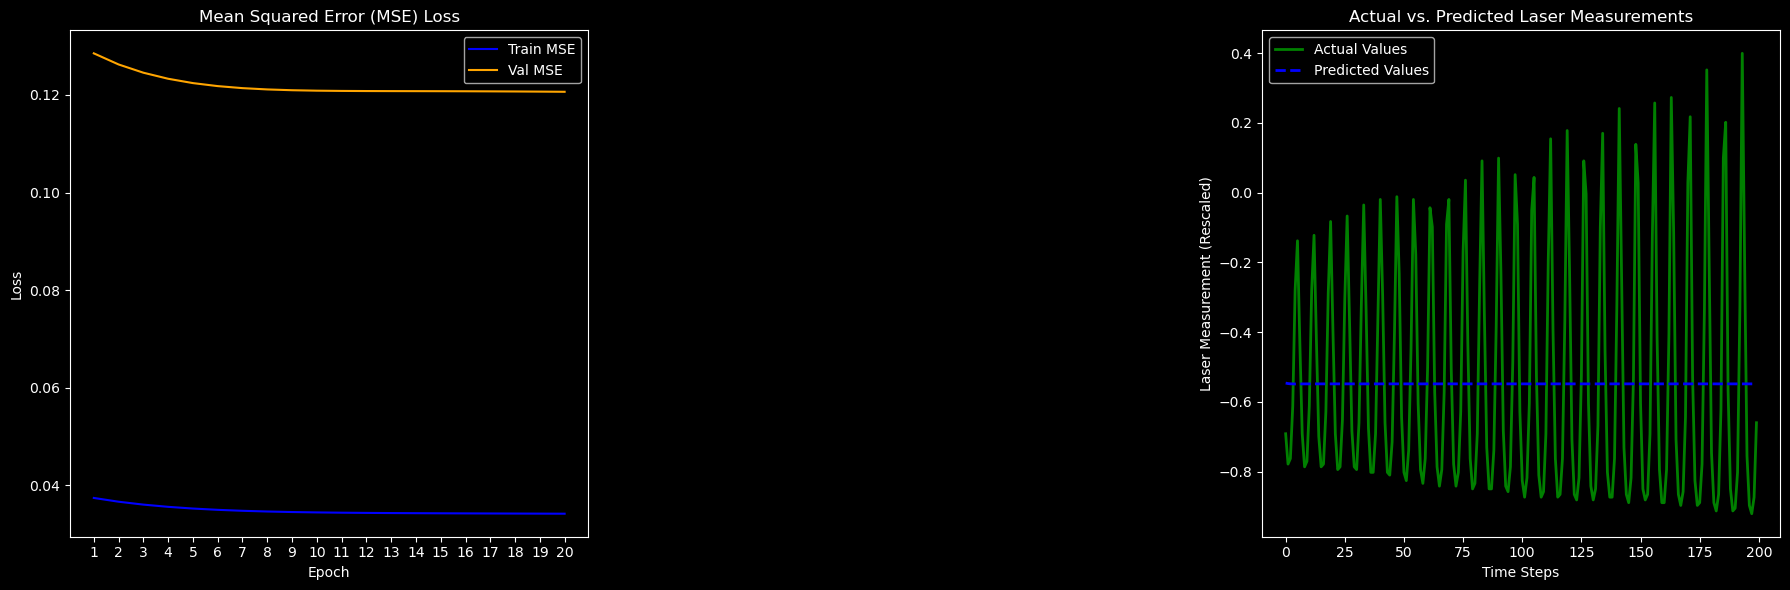

Metrics plot saved to training_summary.png


In [8]:
# Perform recursive forecasting to generate predictions
init_window = torch.tensor(X_val[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window
predictions = recursive_forecast(model, init_window, steps=200)

# Rescale predictions and actual values for comparison
actual_values = y_val[:len(predictions)] # Rescale to the original range

# Plot training and validation metrics
plot_metrics(train_mse_losses, val_mse_losses, train_mae_losses, val_mae_losses, predictions, actual_values)

### Save the trained model

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), "time_series_transformer.pth")
print("Model saved as time_series_transformer.pth")

### Load the trained model

In [ ]:
# Load
model = TimeSeriesTransformer(model_dim=model_dim, num_heads=num_heads, num_layers=num_layers)
model.load_state_dict(torch.load("time_series_transformer.pth"))
model.to(device)

### Predict the next 200 data points recursively

In [ ]:
# Recursive forecasting for 200 steps
init_window = torch.tensor(X_val[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window
predictions = recursive_forecast(model, init_window, steps=200, std=std, mean=mean)

# Debugging: Print raw predictions
print(f"Raw predictions (first 10): {predictions[:10]}")

# Correctly rescale predictions back to the original range
predictions_rescaled = np.array(predictions) * std + mean

# Correctly rescale actual values for comparison
actual_values = y_val[:len(predictions_rescaled)] * std + mean  # Rescale to the original range

# Debugging: Print the ranges of predictions and actual values
print(f"max prediction: {np.max(predictions_rescaled)}, min prediction: {np.min(predictions_rescaled)}")
print(f"max actual: {np.max(actual_values)}, min actual: {np.min(actual_values)}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Laser Measurement (Rescaled)", fontsize=14)
plt.title("Actual vs. Predicted Laser Measurements", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("actual_vs_predicted_plot.png", dpi=300)  # Save the plot as a high-resolution image
plt.show()